In [7]:
from glob import glob
import textworld

In [34]:
filenames_train = glob("./games/debug/train/*.json")
filenames_valid = glob("./games/debug/valid/*.json")
filenames_test = glob("./games/debug/test/*.json")

In [35]:
def load_games(filenames):
    return [textworld.Game.load(filename) for filename in filenames]

games_train = load_games(filenames_train)
games_valid = load_games(filenames_valid)
games_test = load_games(filenames_test)

In [36]:
def get_ingredients(games):
    return [tuple(ingredient) for game in games for ingredient in game.metadata["ingredients"]]

ingredients_train = get_ingredients(games_train)
ingredients_valid = get_ingredients(games_valid)
ingredients_test = get_ingredients(games_test)

/home/macote/.local/venvs/maluuba3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


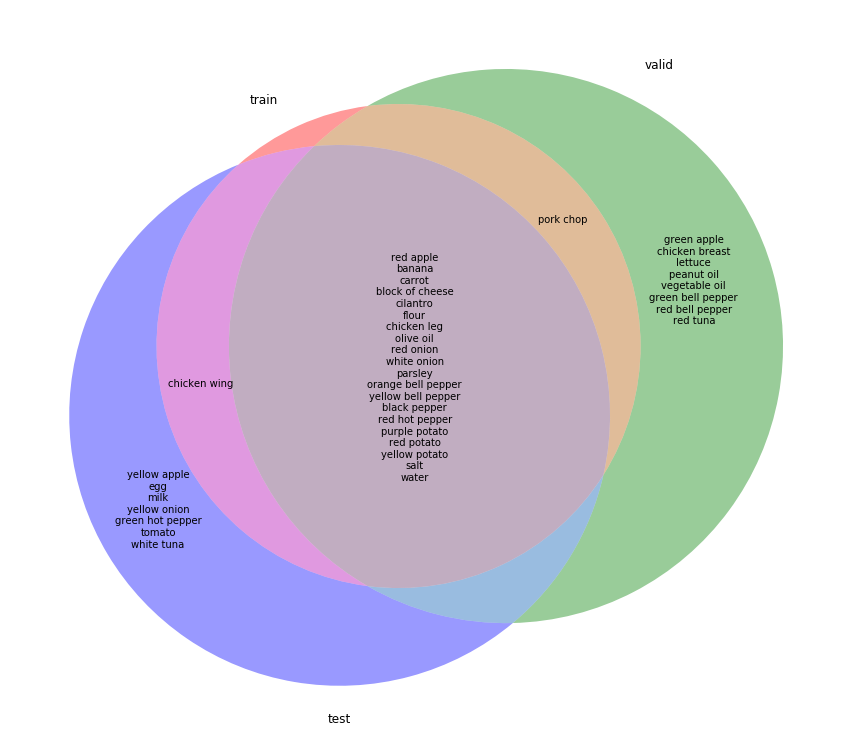

In [38]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def view_dataset(train, valid, test):
    
    def build_formatter_fct():
        cpt = [0]
        def _fct(arg=None):
            if cpt[0] == 0:
                words = set(train) - set(valid) - set(test)
            elif cpt[0] == 1:
                words = set(valid) - set(train) - set(test)
            elif cpt[0] == 2:
                words = (set(train) & set(valid)) - set(test)
            elif cpt[0] == 3:
                words = set(test) - set(valid) - set(train)
            elif cpt[0] == 4:
                words = (set(test) & set(train)) - set(valid)
            elif cpt[0] == 5:
                words = (set(test) & set(valid)) - set(train)
            elif cpt[0] == 6:
                words = set(train) & set(valid) & set(test)
            else:
                return None

            cpt[0] += 1
            return "\n".join(sorted(words, key=lambda s: s.split()[::-1]))
            
        return _fct

    fct = build_formatter_fct()
    subsets = [fct() for _ in range(7)]
    sizes = [len(subset)**0.5 for subset in subsets]

    plt.figure(figsize=(16*1.5,9*1.5))
    venn = venn3(sizes, ("train", "valid", "test"), subset_label_formatter=build_formatter_fct())
    plt.show()
    
view_dataset(set(food for food, _, _ in ingredients_train),
             set(food for food, _, _ in ingredients_valid),
             set(food for food, _, _ in ingredients_test))

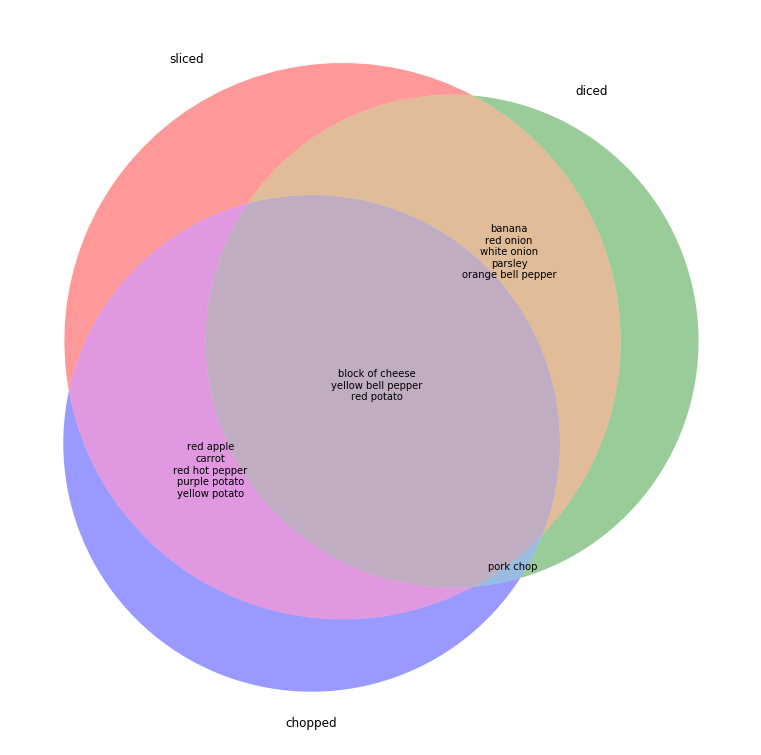

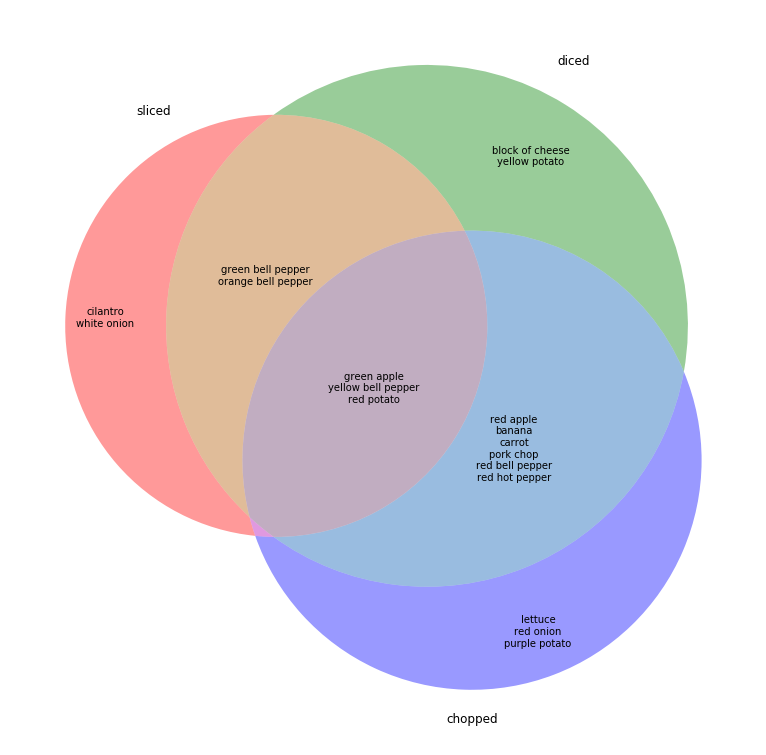

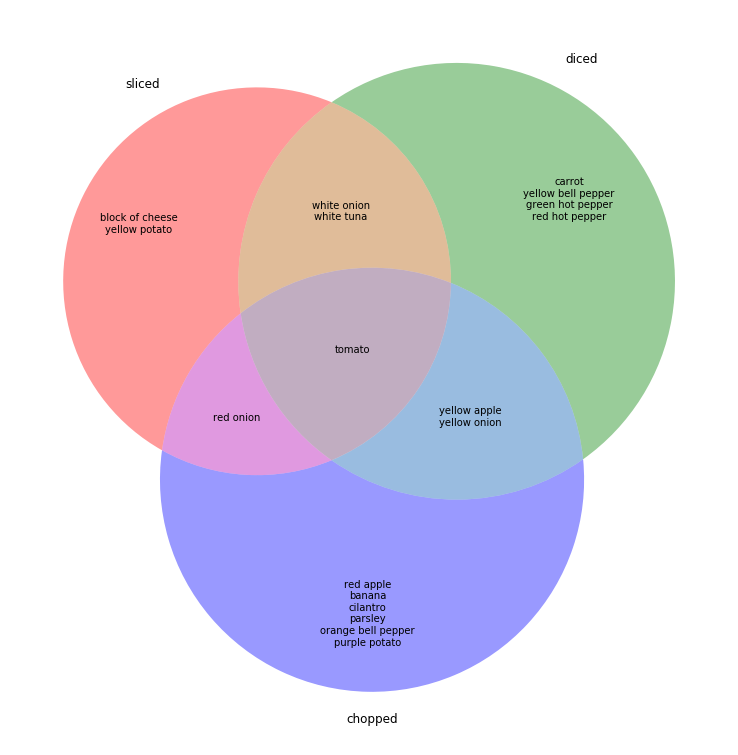

In [40]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def view_dataset(train, valid, test=[]):
    
    def build_formatter_fct():
        cpt = [0]
        def _fct(arg=None):
            if cpt[0] == 0:
                words = set(train) - set(valid) - set(test)
            elif cpt[0] == 1:
                words = set(valid) - set(train) - set(test)
            elif cpt[0] == 2:
                words = (set(train) & set(valid)) - set(test)
            elif cpt[0] == 3:
                words = set(test) - set(valid) - set(train)
            elif cpt[0] == 4:
                words = (set(test) & set(train)) - set(valid)
            elif cpt[0] == 5:
                words = (set(test) & set(valid)) - set(train)
            elif cpt[0] == 6:
                words = set(train) & set(valid) & set(test)
            else:
                return None

            cpt[0] += 1
            return "\n".join(sorted(words, key=lambda s: s.split()[::-1]))
            
        return _fct

    fct = build_formatter_fct()
    subsets = [fct() for _ in range(7)]
    sizes = [len(subset)**0.5 for subset in subsets]

    plt.figure(figsize=(16*1.5,9*1.5))
    venn = venn3(sizes, ("sliced", "diced", "chopped"), subset_label_formatter=build_formatter_fct())
    plt.show()

view_dataset([ingredient[0] for ingredient in ingredients_train if ingredient[2] == "sliced"],
             [ingredient[0] for ingredient in ingredients_train if ingredient[2] == "diced"],
             [ingredient[0] for ingredient in ingredients_train if ingredient[2] == "chopped"],)

view_dataset([ingredient[0] for ingredient in ingredients_valid if ingredient[2] == "sliced"],
             [ingredient[0] for ingredient in ingredients_valid if ingredient[2] == "diced"],
             [ingredient[0] for ingredient in ingredients_valid if ingredient[2] == "chopped"],)


view_dataset([ingredient[0] for ingredient in ingredients_test if ingredient[2] == "sliced"],
             [ingredient[0] for ingredient in ingredients_test if ingredient[2] == "diced"],
             [ingredient[0] for ingredient in ingredients_test if ingredient[2] == "chopped"],)

/home/macote/.local/venvs/maluuba3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


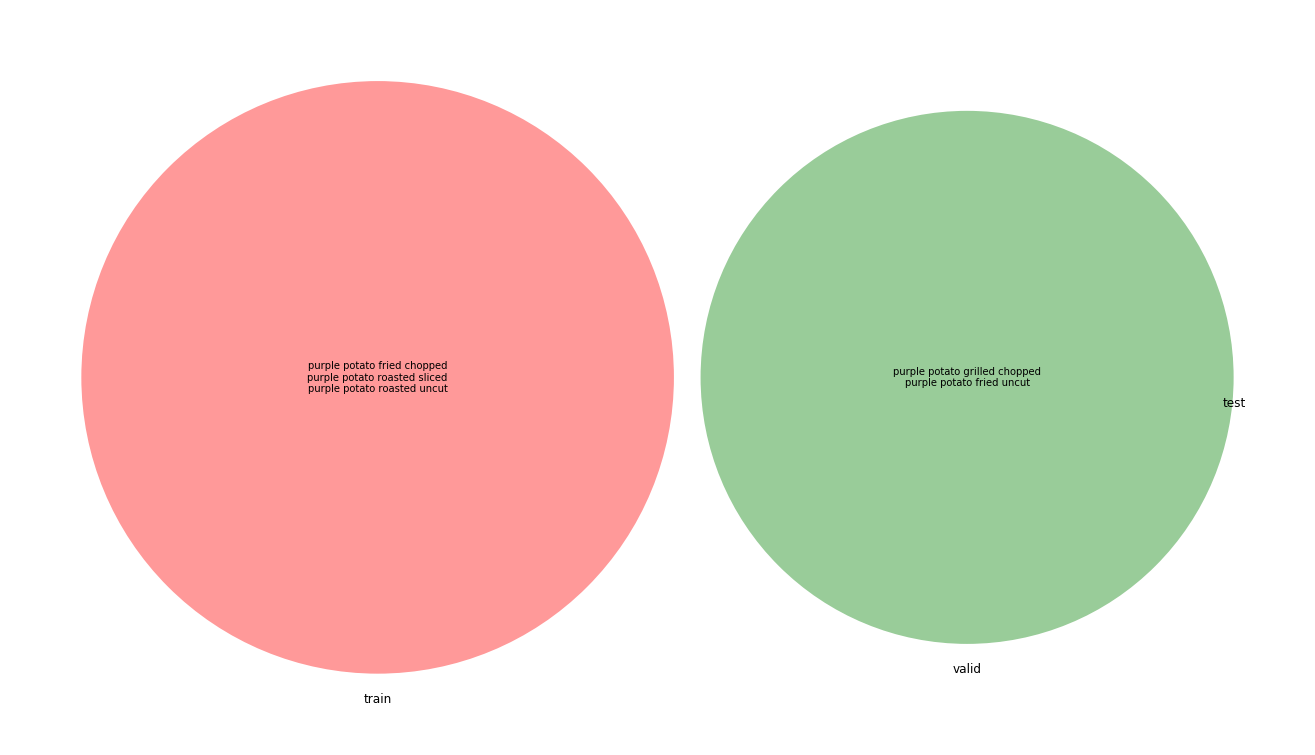

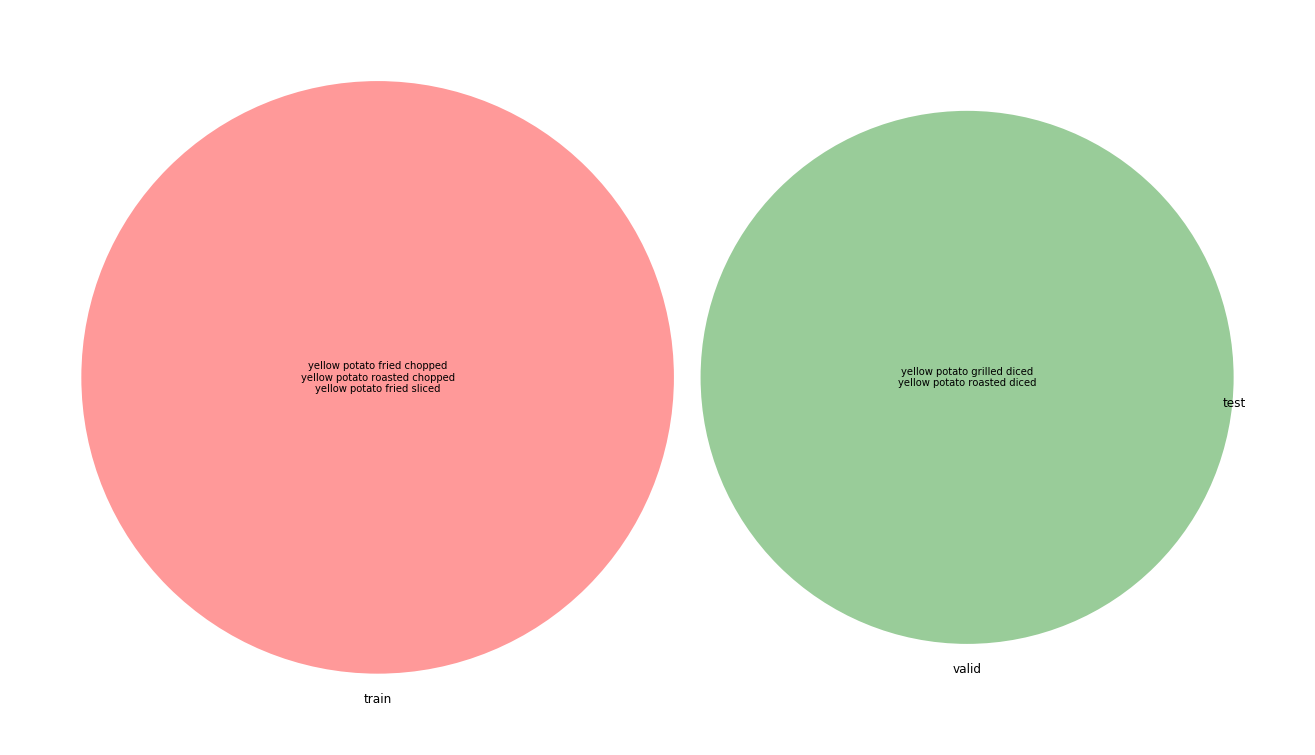

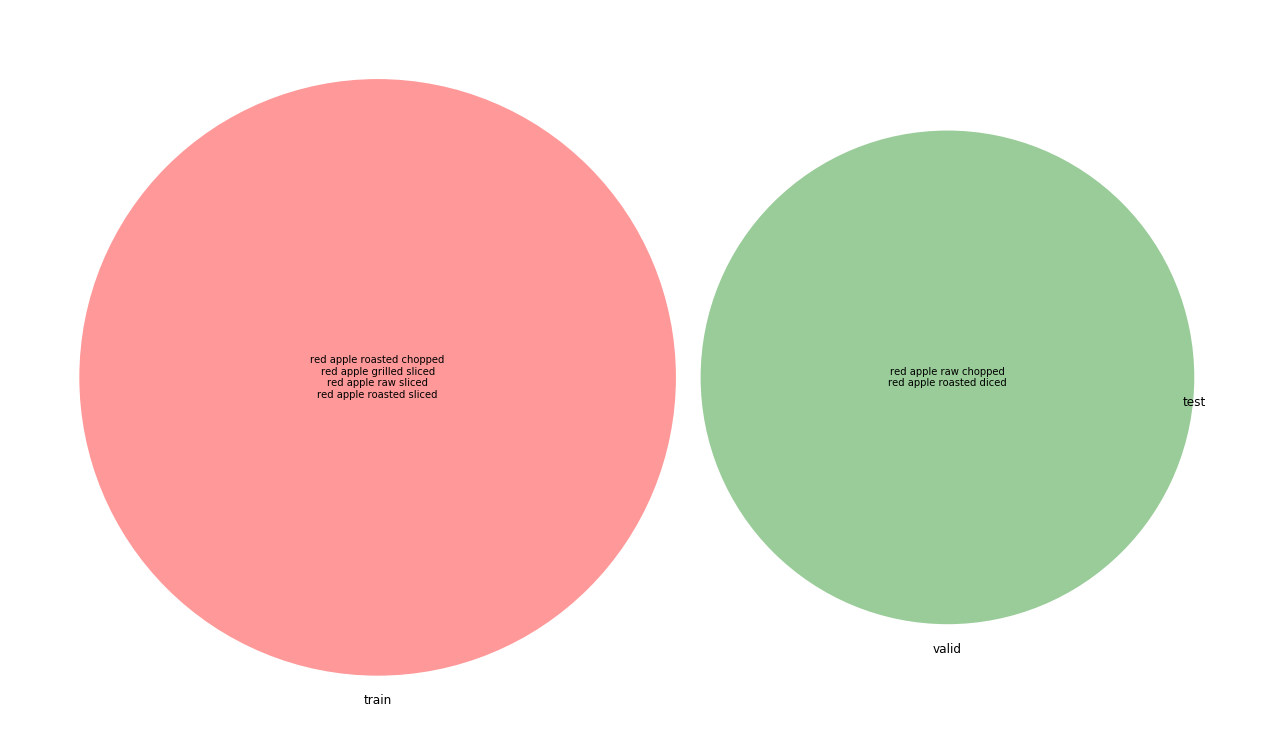

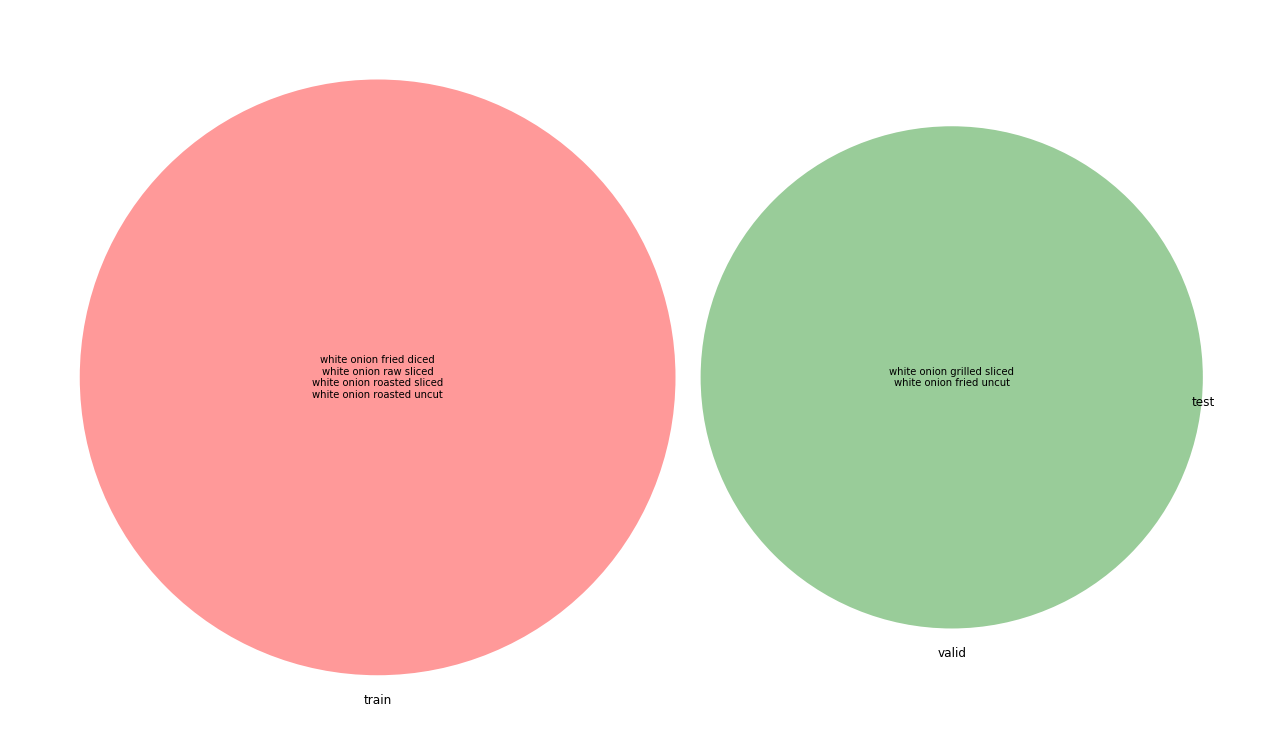

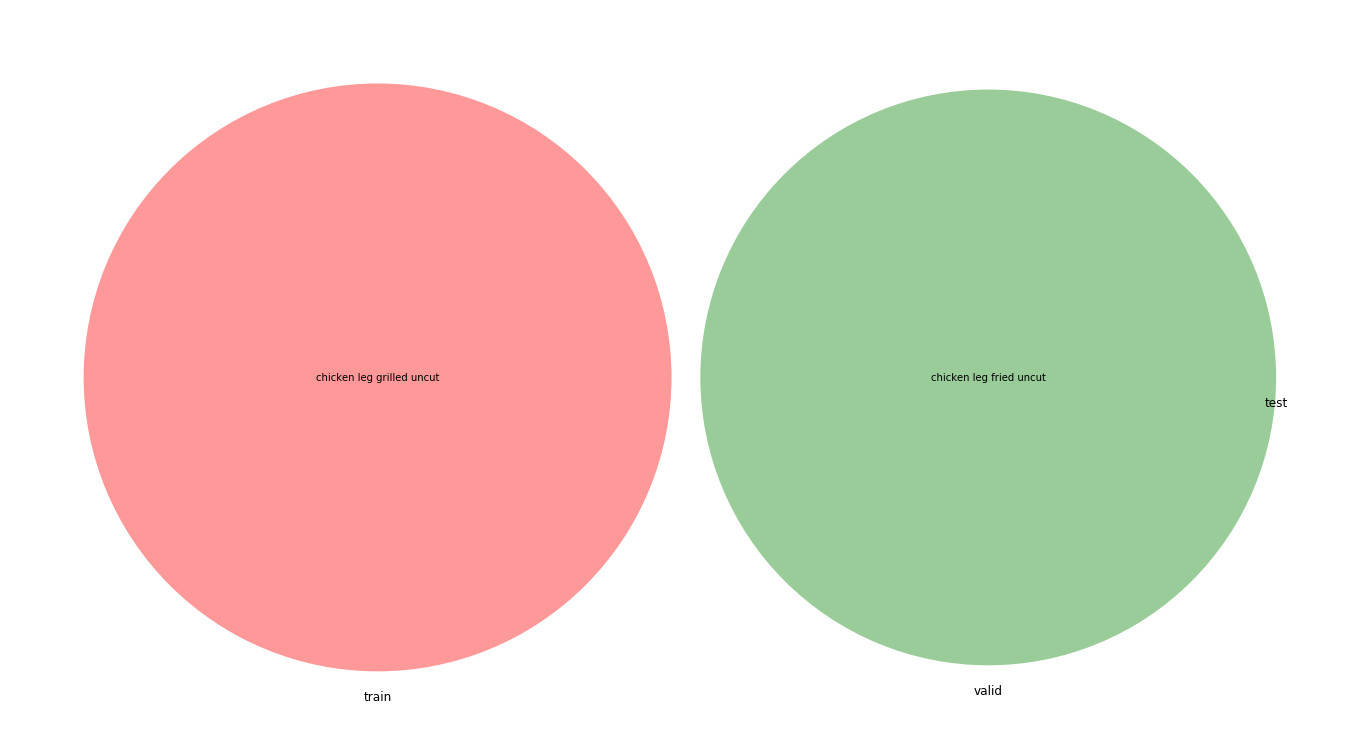

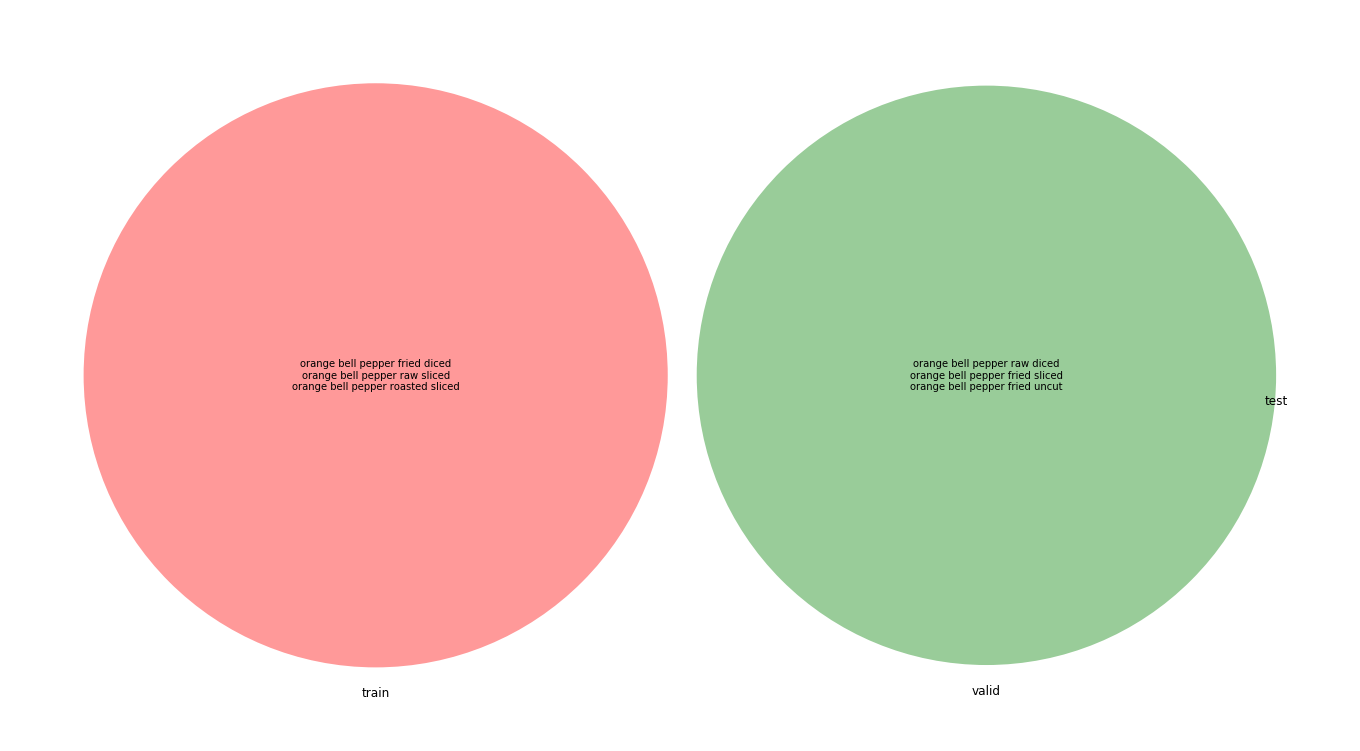

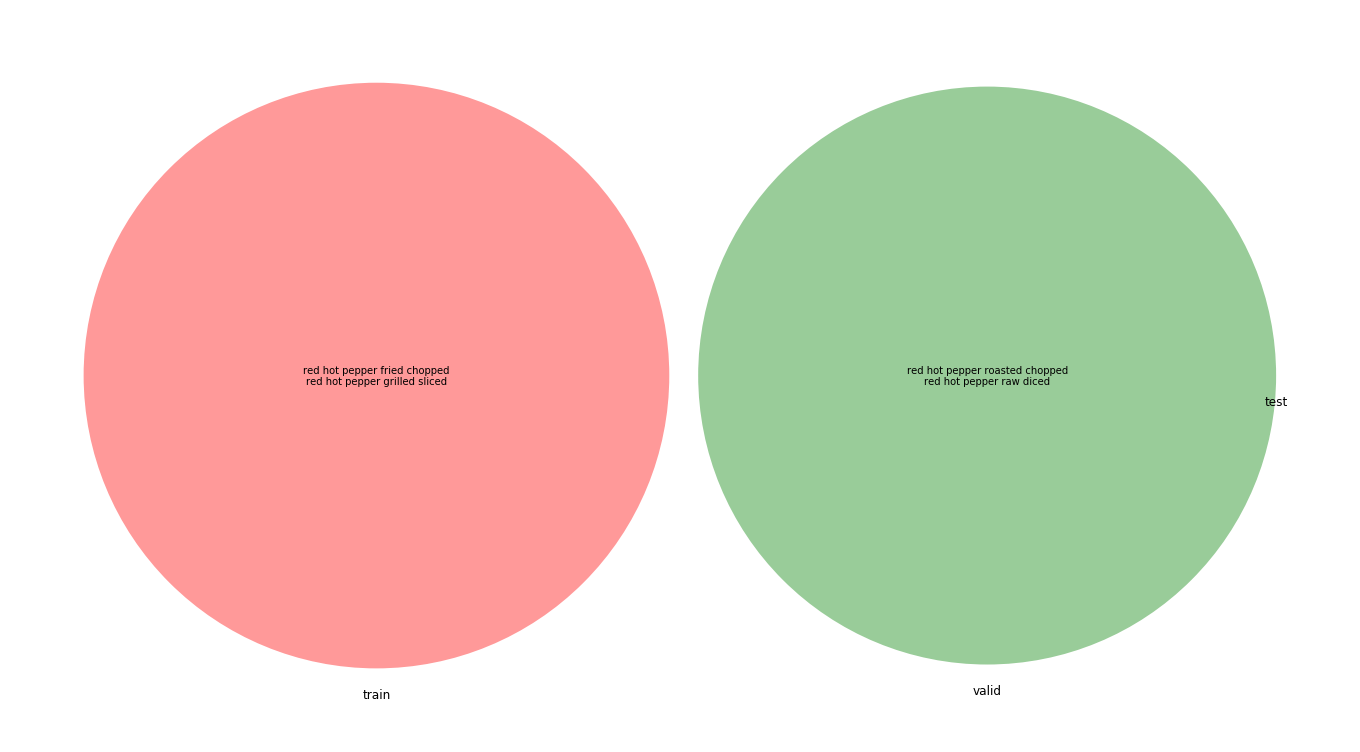

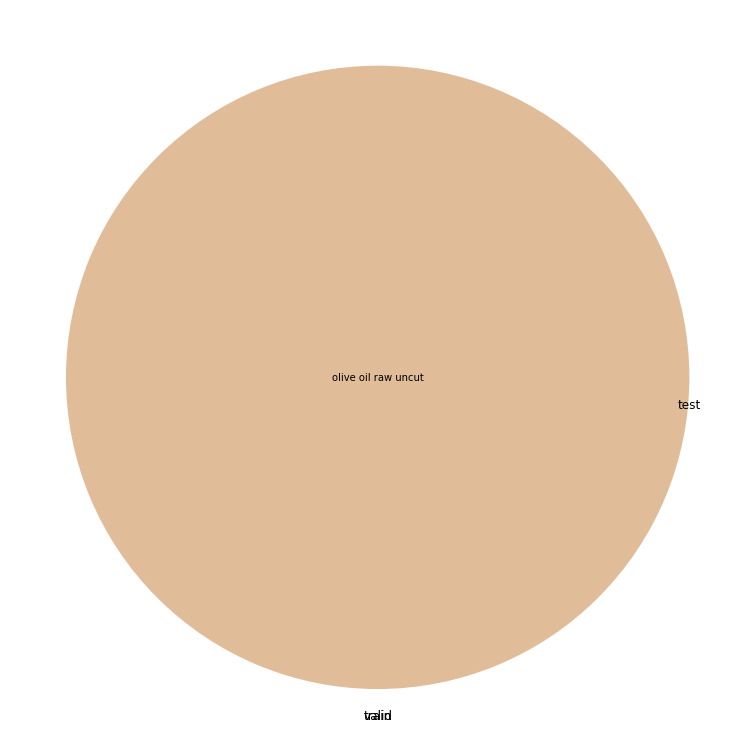

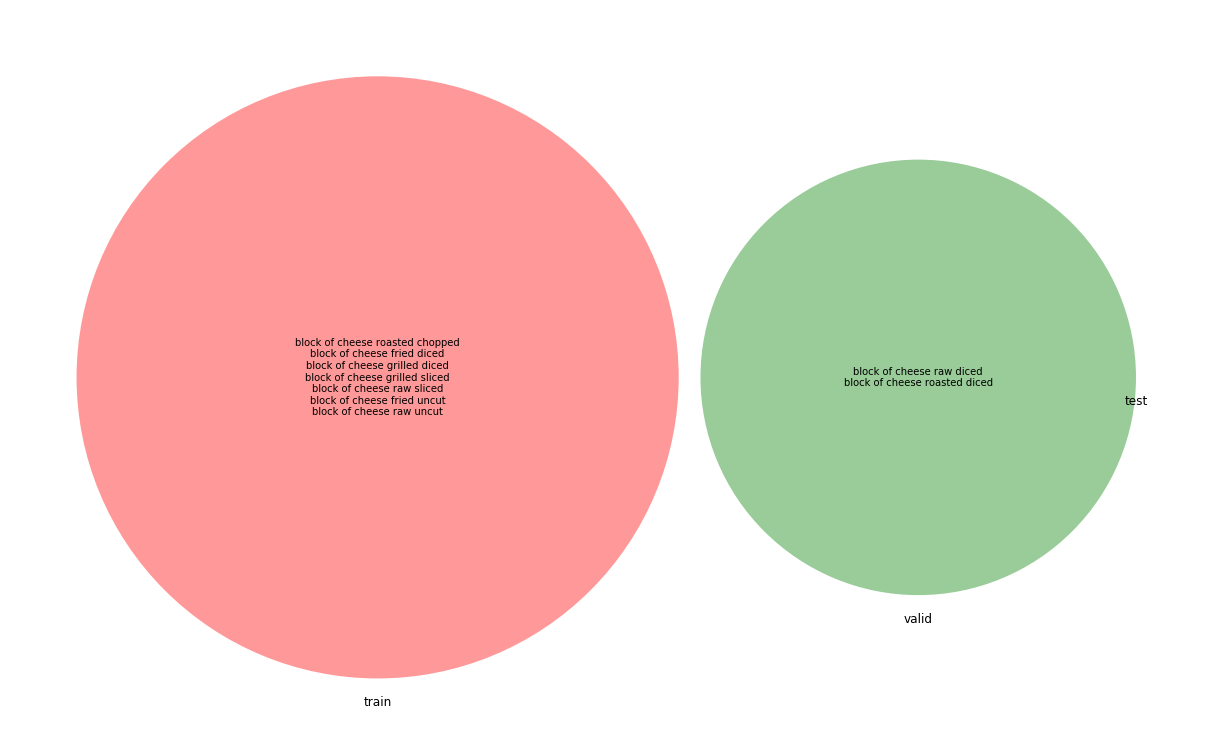

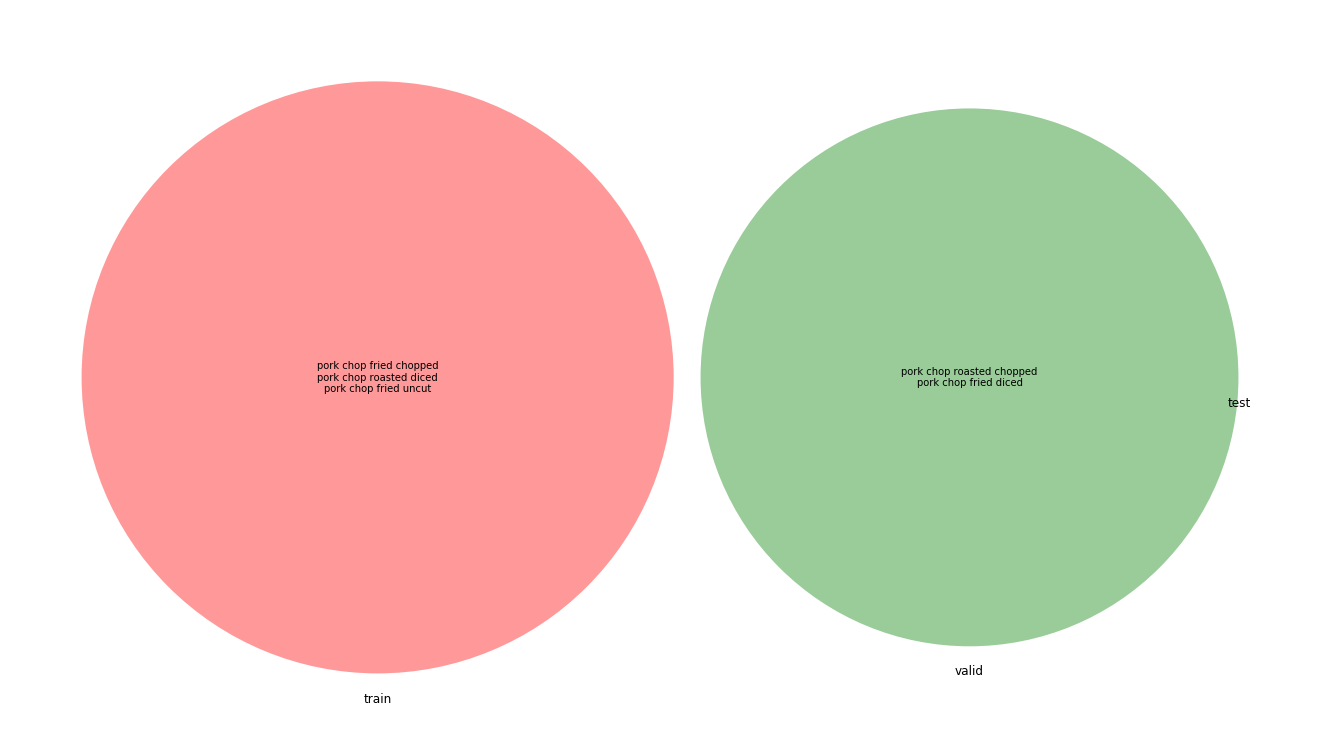

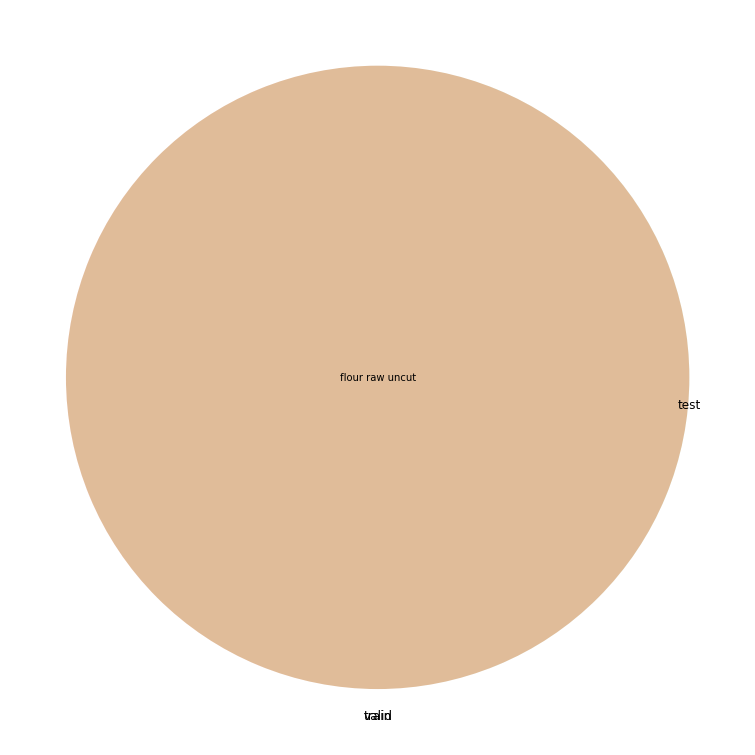

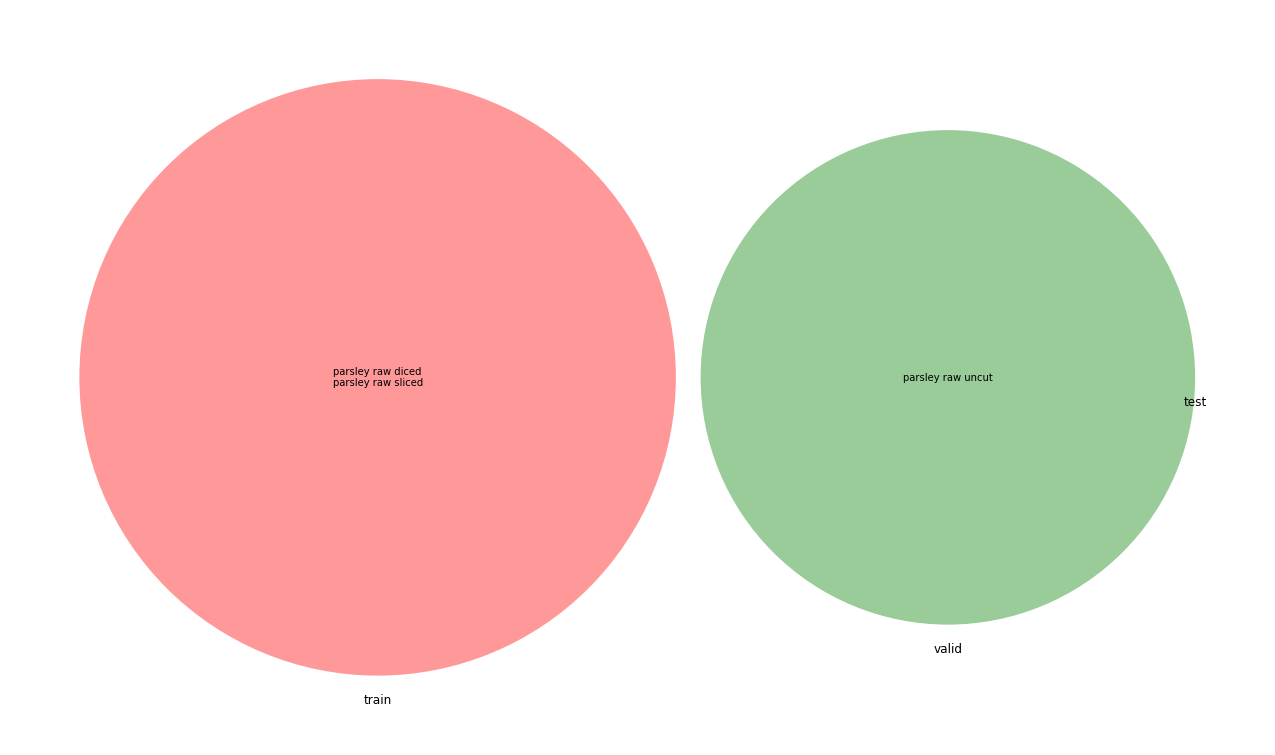

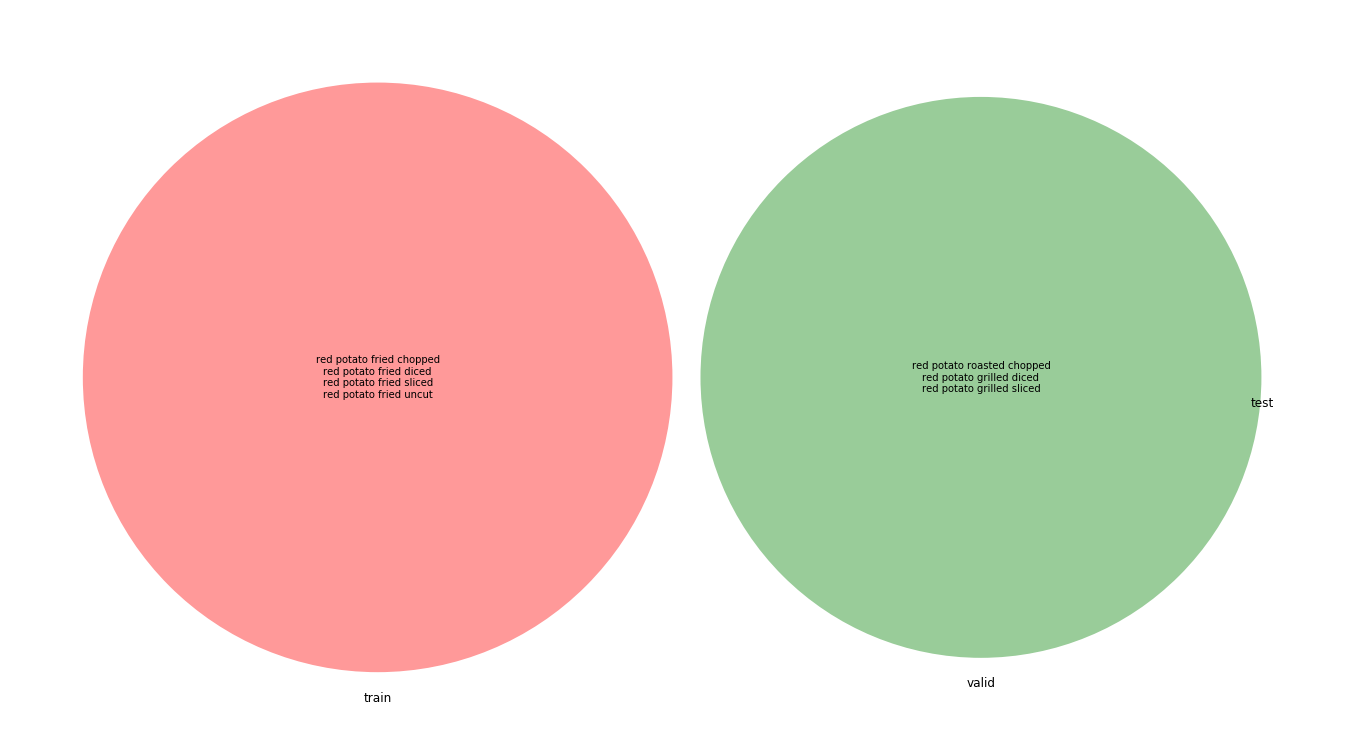

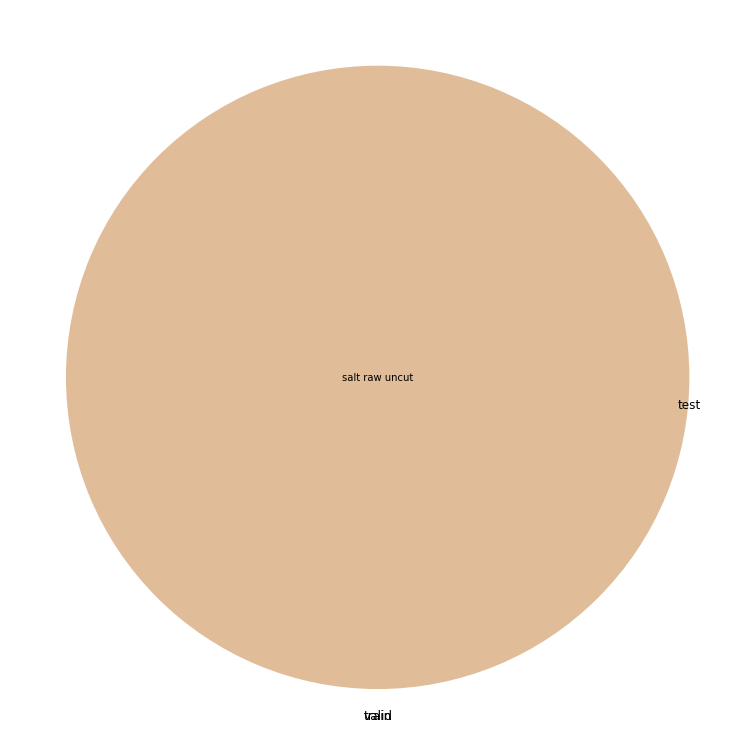

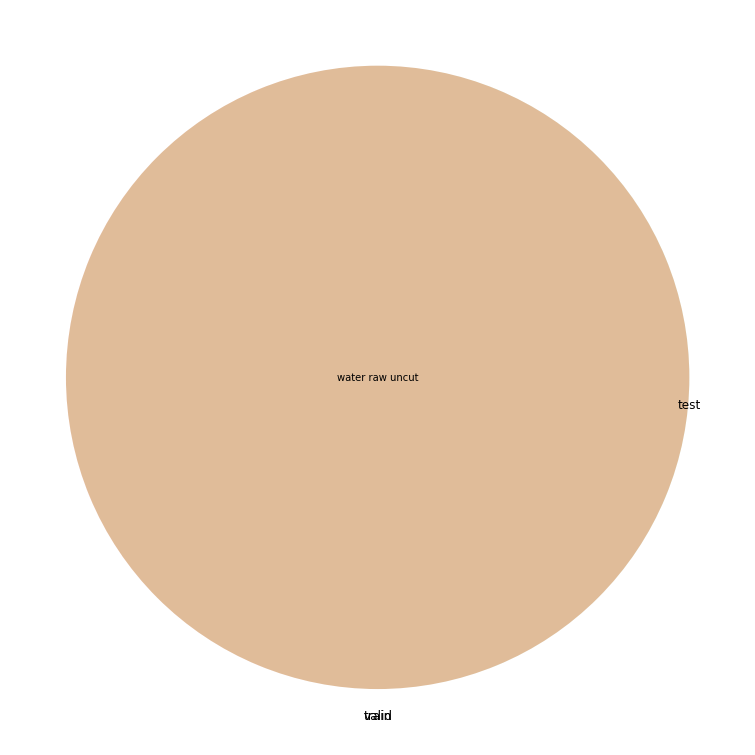

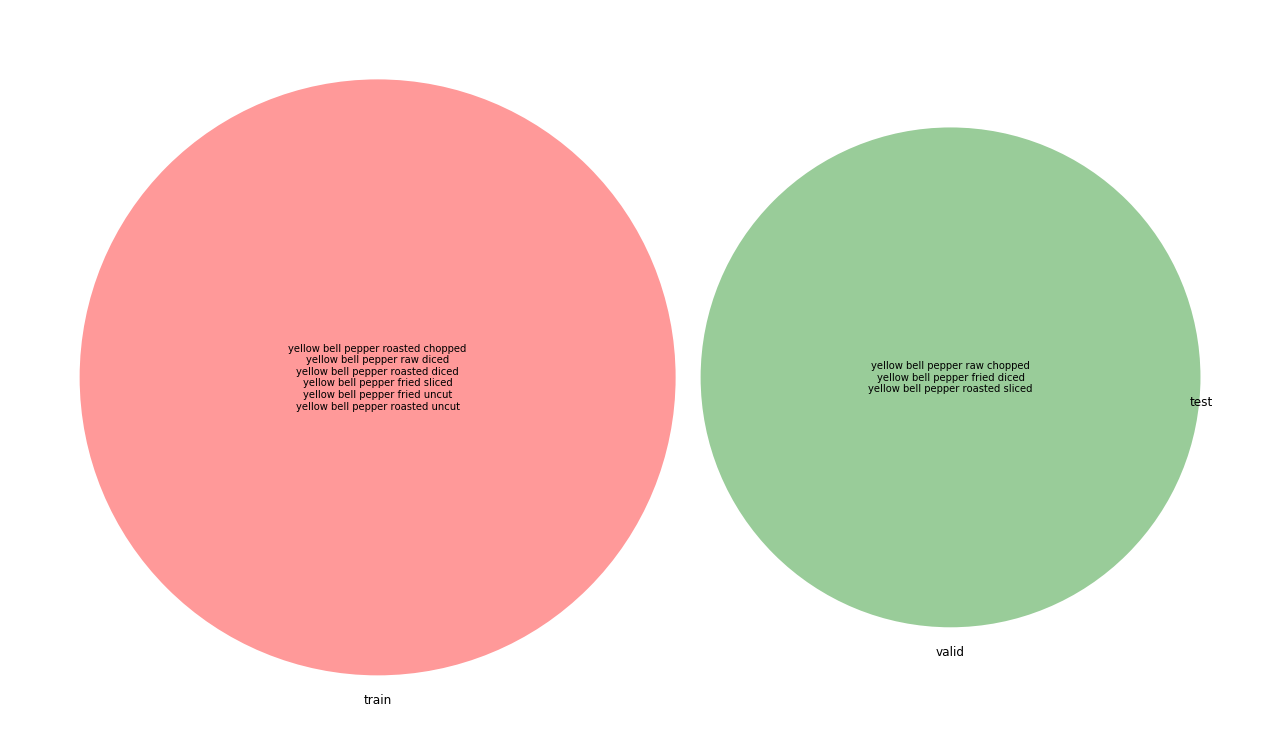

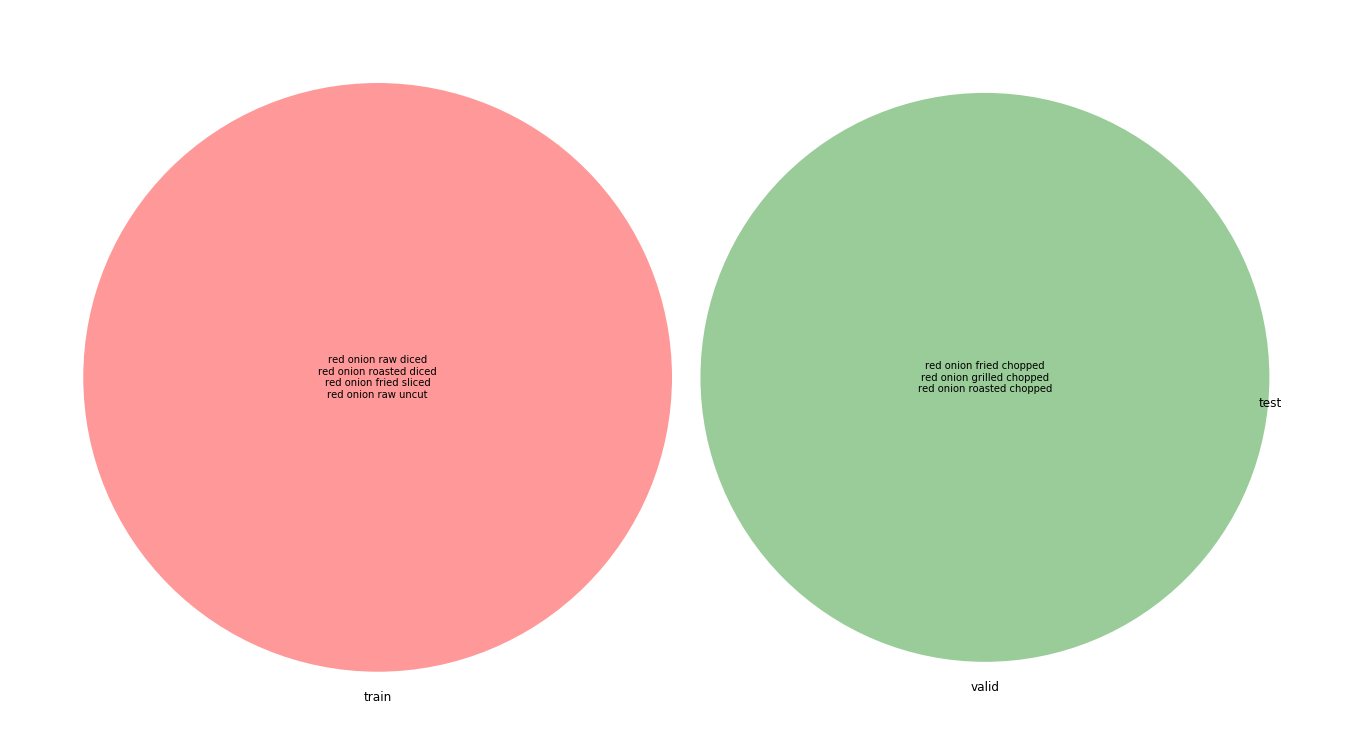

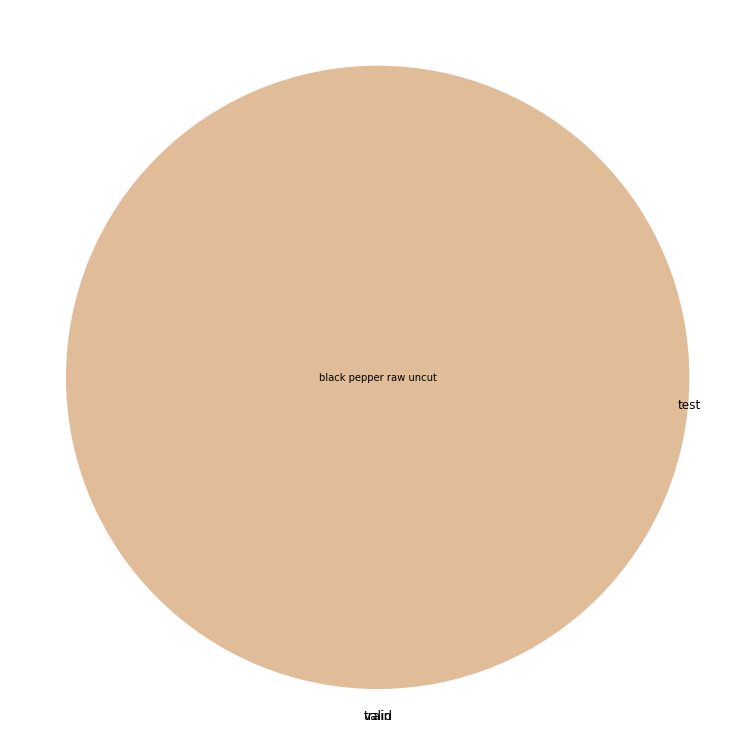

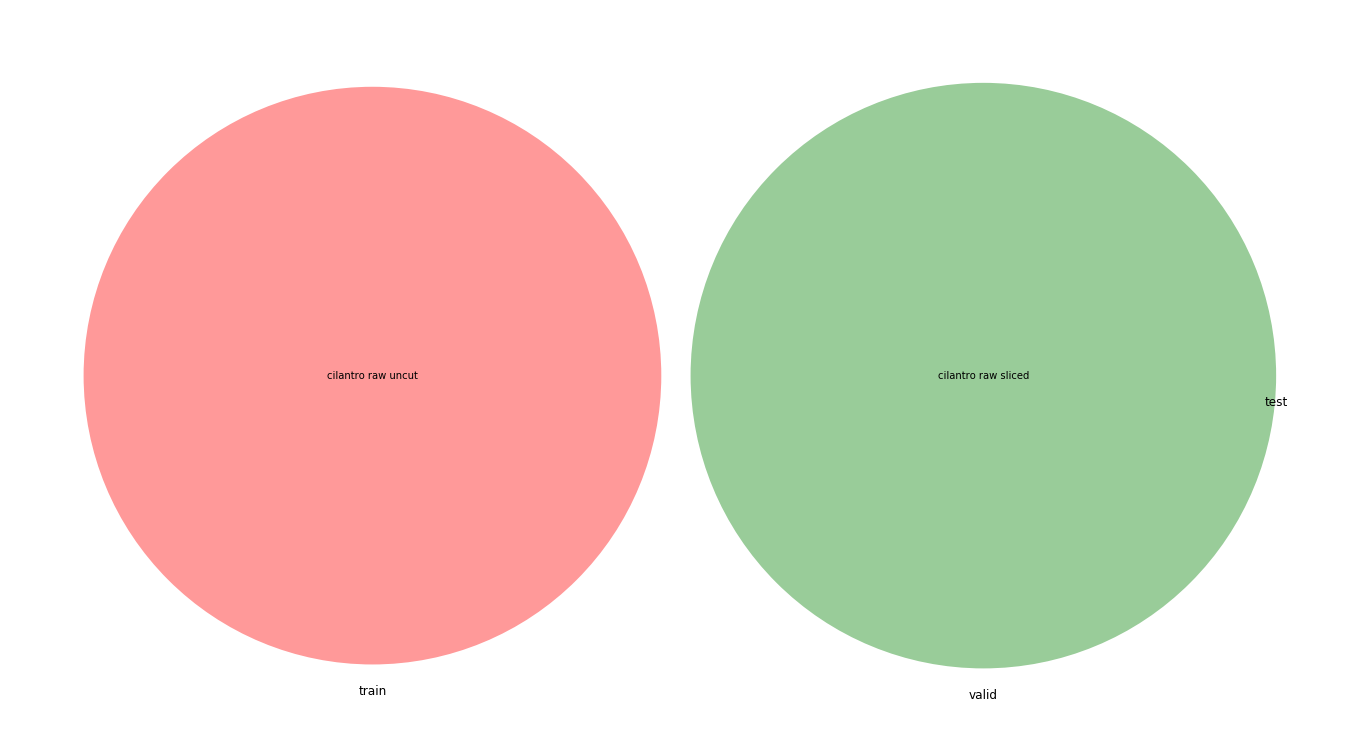

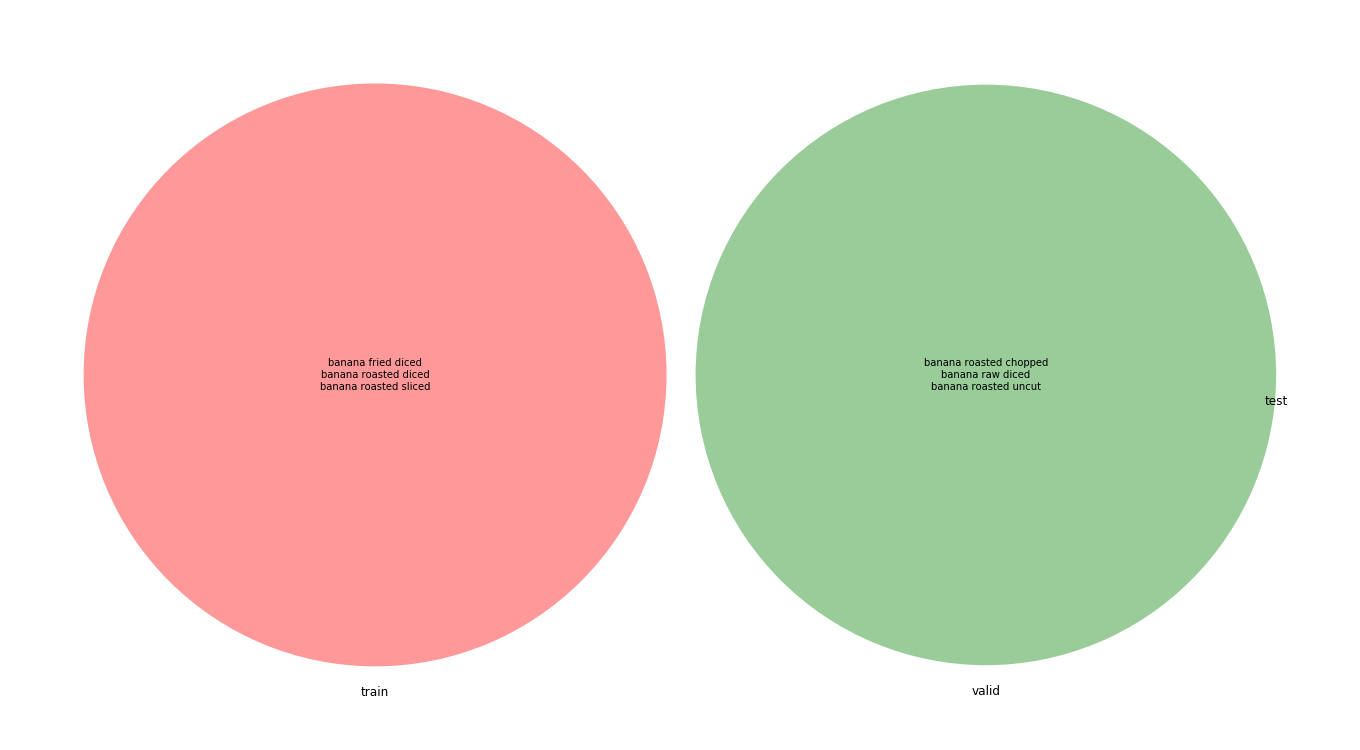

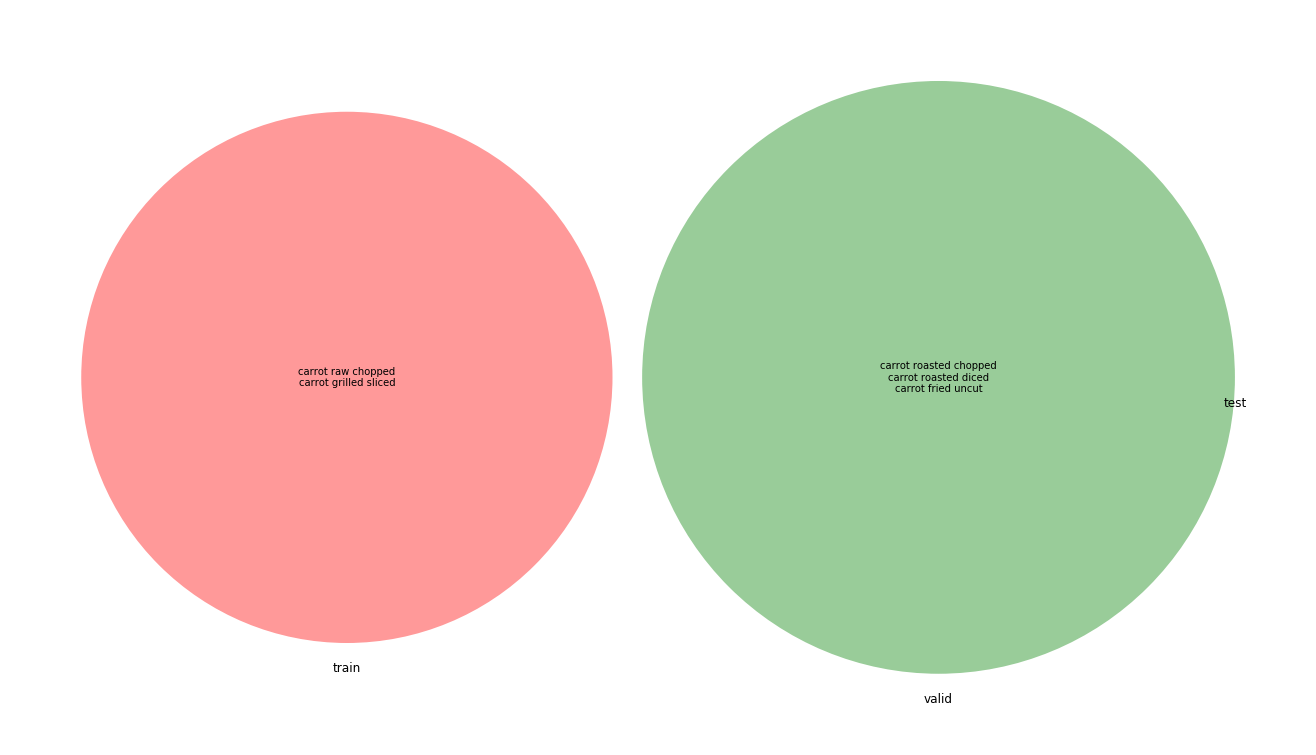

In [28]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def view_dataset(train, valid, test=[]):
    
    def build_formatter_fct():
        cpt = [0]
        def _fct(arg=None):
            if cpt[0] == 0:
                words = set(train) - set(valid) - set(test)
            elif cpt[0] == 1:
                words = set(valid) - set(train) - set(test)
            elif cpt[0] == 2:
                words = (set(train) & set(valid)) - set(test)
            elif cpt[0] == 3:
                words = set(test) - set(valid) - set(train)
            elif cpt[0] == 4:
                words = (set(test) & set(train)) - set(valid)
            elif cpt[0] == 5:
                words = (set(test) & set(valid)) - set(train)
            elif cpt[0] == 6:
                words = set(train) & set(valid) & set(test)
            else:
                return None

            cpt[0] += 1
            return "\n".join(sorted(words, key=lambda s: s.split()[::-1]))
            
        return _fct

    fct = build_formatter_fct()
    subsets = [fct() for _ in range(7)]
    sizes = [len(subset)**0.5 for subset in subsets]

    plt.figure(figsize=(16*1.5,9*1.5))
    venn = venn3(sizes, ("train", "valid", "test"), subset_label_formatter=build_formatter_fct())
    plt.show()

foods_train = set(food for food, _, _ in ingredients_train)
foods_valid = set(food for food, _, _ in ingredients_valid)
common_food = foods_train & foods_valid

for food in common_food:
    view_dataset([ingredient for ingredient in ingredients_train if ingredient[0] == food],
                 [ingredient for ingredient in ingredients_valid if ingredient[0] == food])